In [1]:
import torch
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(torch.get_default_device())

2.7.1+cu126
cuda:0


In [2]:
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)+1

def unicode_to_ascii(s: str) -> str:
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn' and c in all_letters)

def read_lines(filename: str):
    with open(filename, encoding='utf-8') as f:
        return [unicode_to_ascii(line.strip()) for line in f]

cateogry_lines = {}
all_categories = []
for filename in glob.glob("data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    cateogry_lines[category] = lines

n_categories = len(all_categories)

print(n_categories, all_categories)

18 ['Portuguese', 'English', 'Korean', 'Italian', 'Scottish', 'Czech', 'Greek', 'German', 'Polish', 'Chinese', 'Spanish', 'Japanese', 'French', 'Irish', 'Russian', 'Dutch', 'Arabic', 'Vietnamese']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# LSTM from scratch, why not https://colah.github.io/posts/2015-08-Understanding-LSTMs/
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(LSTM, self).__init__()
        self.forget = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.input = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.candidate = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.output = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

    def forward(self, category, input, hidden, cell):
        comb = torch.cat((category, input, hidden), 1)

        forget_gate = F.sigmoid(self.forget(comb))
        cell_state = forget_gate * cell

        input_gate = F.sigmoid(self.input(comb))
        candidate_cell = F.tanh(self.candidate(comb))

        cell_state += input_gate * candidate_cell

        output_gate = F.sigmoid(self.output(comb))
        hidden_state = output_gate * F.tanh(cell_state)

        output = F.log_softmax(self.h2o(hidden_state))

        return output, hidden_state, cell_state



class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.drop = nn.Dropout(0.1)
        self.act = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        comb = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(comb)
        output = self.i2o(comb)
        output_comb = torch.cat((hidden, output), 1)
        output = self.o2o(output_comb)
        output = self.drop(output)
        output = self.act(output)
        return output, hidden


In [4]:
import random

def random_choice(l: list):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair():
    cat = random_choice(all_categories)
    line = random_choice(cateogry_lines[cat])
    return cat, line

In [5]:
def cat_tensor(cat: str) -> torch.Tensor:
    idx = all_categories.index(cat)
    t = torch.zeros(1, n_categories).to(device)
    t[0][idx] = 1
    return t

def inp_tensor(line: str) -> torch.Tensor:
    t = torch.zeros(len(line), 1, n_letters).to(device)
    for idx, letter in enumerate(line):
        letter_idx = all_letters.find(letter)
        t[idx][0][letter_idx] = 1
    return t

def target_tensor(line: str) -> torch.Tensor:
    letter_indices = [all_letters.find(line[idx]) for idx in range(1, len(line))]
    letter_indices.append(n_letters - 1)
    return torch.LongTensor(letter_indices).to(device)

In [6]:
def random_training_example():
    cat, line = random_training_pair()
    category_tensor = cat_tensor(cat)
    input_line_tensor = inp_tensor(line)
    target_line_tensor = target_tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor


In [7]:
from tqdm import trange

loss_fn = nn.NLLLoss()

lr = 0.0005
nepochs = 100000
all_losses = []
total_loss = 0

rnn = LSTM(n_letters, 128, n_letters)

for epoch in (pbar := trange(1, nepochs+1)):
    category_tensor, input_line_tensor, target_line_tensor = random_training_example()
    target_line_tensor = target_line_tensor.unsqueeze_(-1)
    hidden = torch.zeros(1, rnn.hidden_size).to(device)
    cell = torch.zeros(1, rnn.hidden_size).to(device)

    rnn.zero_grad()
    loss = 0.0

    for i in range(input_line_tensor.size(0)):
        out, hidden, cell = rnn(category_tensor, input_line_tensor[i], hidden, cell)
        l = loss_fn(out, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    total_loss += loss.item() / input_line_tensor.size(0)
    if epoch % 500 == 0:
        all_losses.append(total_loss / 500)
        total_loss = 0
        pbar.set_description(f"Epoch {epoch}, loss: {all_losses[-1]:.4f}")


  0%|          | 0/100000 [00:00<?, ?it/s]/home/hxwk/ml/nlp/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)
Epoch 100000, loss: 2.4555: 100%|██████████| 100000/100000 [18:38<00:00, 89.37it/s]


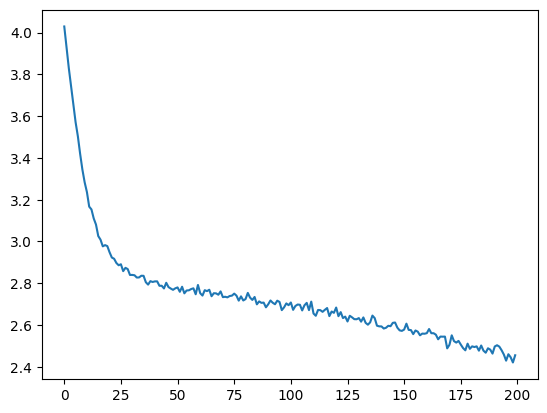

In [8]:
import matplotlib.pyplot as plt

plt.plot(all_losses)

In [14]:
torch.save(rnn.state_dict(), 'gen-lstm-1.pth')

In [12]:
max_length = 20

def sample(category: str, start_letter: str):
    with torch.no_grad():
        category_tensor = cat_tensor(category)
        inp = inp_tensor(start_letter)
        hidden = torch.zeros(1, rnn.hidden_size).to(device)
        cell = torch.zeros(1, rnn.hidden_size).to(device)

        output_name = start_letter

        for _ in range(max_length):
            output, hidden, cell = rnn(category_tensor, inp[0], hidden, cell)
            _, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            inp = inp_tensor(letter)

        return output_name
            

def samples(category: str, start_letters: str):
    for start_letter in start_letters:
        print(sample(category, start_letter))


In [13]:
samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Ranan
Uanan
Sanan
Garer
Eanen
Ranen
Saran
Paran
Aaran
Can
Han
Ian


/home/hxwk/ml/nlp/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)
